In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, precision_recall_curve, auc
)
from sklearn.inspection import permutation_importance
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from google.colab import files

In [4]:
df = pd.read_csv("/content/loan_data_clean.csv")
X = df.drop(columns=["loan_status"])
y = df["loan_status"].astype(int)

In [5]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Data loading complete")
print(f"  Training set: {X_train.shape} | Test set: {X_test.shape}")


Data loading complete
  Training set: (36000, 24) | Test set: (9000, 24)


In [7]:
train_df = pd.concat([y_train.reset_index(drop=True), X_train.reset_index(drop=True)], axis=1)
train_df.to_csv("/content/loan_train.csv", index=False)
files.download("/content/loan_train.csv")
print(f" Training set exported and downloaded: {train_df.shape}")
print(f"  Filename: loan_train.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Training set exported and downloaded: (36000, 25)
  Filename: loan_train.csv


In [8]:
test_df = pd.concat([y_test.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)
test_df.to_csv("/content/loan_test.csv", index=False)
files.download("/content/loan_test.csv")
print(f"Test set exported and downloaded: {test_df.shape}")
print(f"  Filename: loan_test.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test set exported and downloaded: (9000, 25)
  Filename: loan_test.csv


In [9]:
cw = class_weight.compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), cw))
scale_pos_weight = class_weight_dict[1] / class_weight_dict[0]

In [10]:
key_feat = "previous_loan_defaults_on_file"
X_train_drop = X_train.drop(columns=[key_feat])
X_test_drop = X_test.drop(columns=[key_feat])

print(f" Removed feature: {key_feat}")
print(f"  New feature count: {X_train_drop.shape[1]}")

 Removed feature: previous_loan_defaults_on_file
  New feature count: 23


In [11]:
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
)

In [12]:
param_dist = {
    "n_estimators": [400, 600, 800],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.03, 0.05, 0.08],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.6, 0.75, 0.9],
    "min_child_weight": [3, 5, 8],
    "gamma": [0, 0.1, 0.2],
    "reg_alpha": [0, 0.3, 0.6],
    "reg_lambda": [0.8, 1.0, 1.5],
}

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [16]:
search.fit(X_train_drop, y_train)
model = search.best_estimator_

print(f"\n Best parameters: {search.best_params_}")
print(f" CV AUC: {search.best_score_:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits

 Best parameters: {'subsample': 0.85, 'reg_lambda': 0.8, 'reg_alpha': 0, 'n_estimators': 600, 'min_child_weight': 8, 'max_depth': 4, 'learning_rate': 0.08, 'gamma': 0.2, 'colsample_bytree': 0.6}
 CV AUC: 0.9355


In [17]:
proba = model.predict_proba(X_test_drop)[:, 1]

In [18]:
precisions, recalls, thresholds = precision_recall_curve(y_test, proba)
precisions_cut = precisions[:-1]
recalls_cut = recalls[:-1]
f1_array = 2 * precisions_cut * recalls_cut / (precisions_cut + recalls_cut + 1e-9)
best_f1_idx = np.argmax(f1_array)
best_thr = thresholds[best_f1_idx] if len(thresholds) > 0 else 0.5

pred_05 = (proba >= 0.5).astype(int)
pred_opt = (proba >= best_thr).astype(int)

print(f"Best threshold: {best_thr:.3f}")

Best threshold: 0.647


In [19]:
auc_score = roc_auc_score(y_test, proba)
acc_05 = accuracy_score(y_test, pred_05)
prec_05 = precision_score(y_test, pred_05)
rec_05 = recall_score(y_test, pred_05)
f1_05 = f1_score(y_test, pred_05)


In [21]:
acc_opt = accuracy_score(y_test, pred_opt)
prec_opt = precision_score(y_test, pred_opt)
rec_opt = recall_score(y_test, pred_opt)
f1_opt = f1_score(y_test, pred_opt)
print(f"\n[Threshold=0.5] AUC={auc_score:.4f} | ACC={acc_05:.4f} | PREC={prec_05:.4f} | REC={rec_05:.4f} | F1={f1_05:.4f}")
print(f"[Threshold={best_thr:.3f}] ACC={acc_opt:.4f} | PREC={prec_opt:.4f} | REC={rec_opt:.4f} | F1={f1_opt:.4f}")


[Threshold=0.5] AUC=0.9393 | ACC=0.8904 | PREC=0.7302 | REC=0.8040 | F1=0.7653
[Threshold=0.647] ACC=0.9150 | PREC=0.8617 | REC=0.7355 | F1=0.7936


In [22]:
cm_05 = confusion_matrix(y_test, pred_05)
cm_opt = confusion_matrix(y_test, pred_opt)

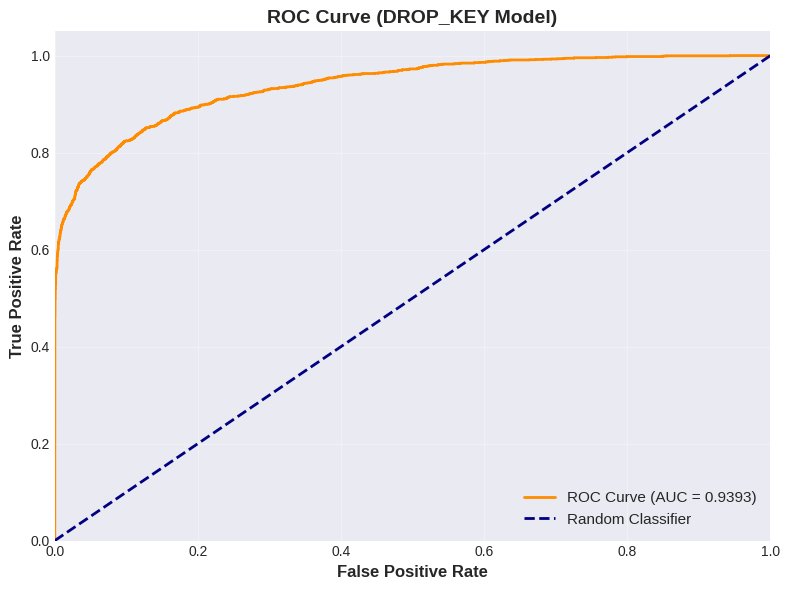

In [20]:
fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curve (DROP_KEY Model)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('/content/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

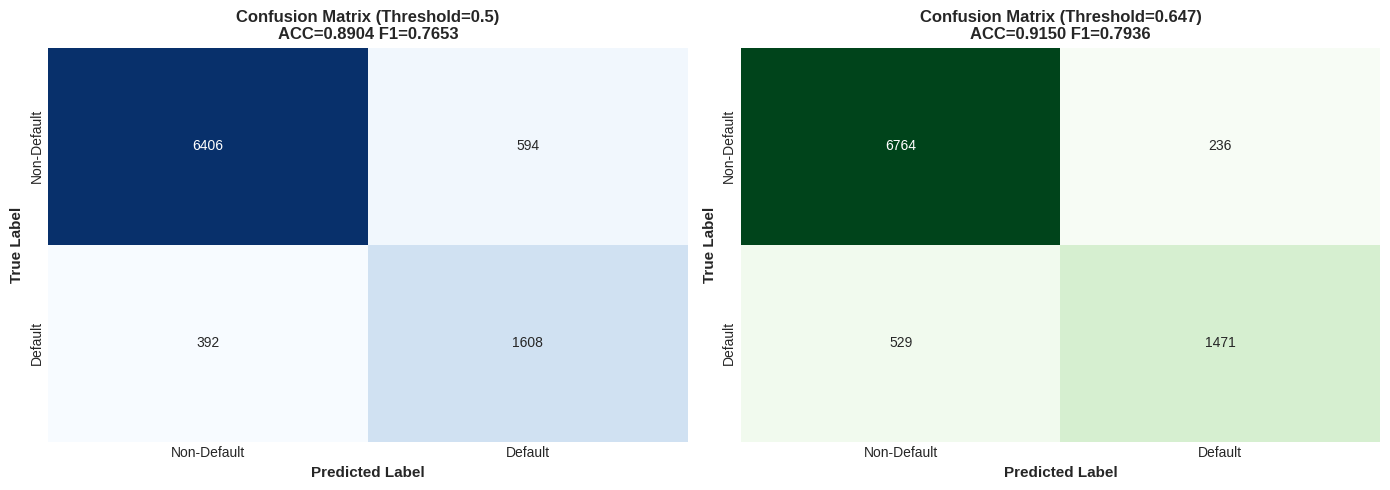

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_05, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False,
            xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
axes[0].set_title(f'Confusion Matrix (Threshold=0.5)\nACC={acc_05:.4f} F1={f1_05:.4f}',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')

sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False,
            xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
axes[1].set_title(f'Confusion Matrix (Threshold={best_thr:.3f})\nACC={acc_opt:.4f} F1={f1_opt:.4f}',
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

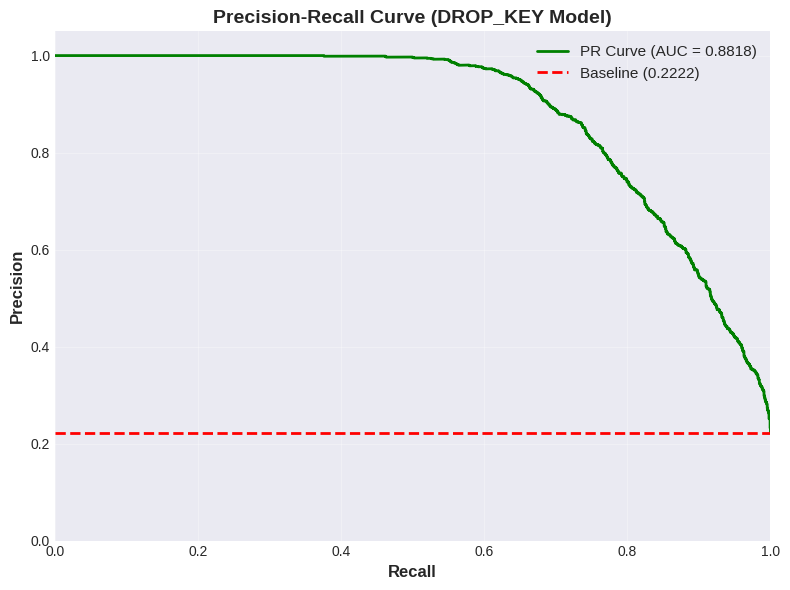

In [24]:
precisions_pr, recalls_pr, _ = precision_recall_curve(y_test, proba)
pr_auc = auc(recalls_pr, precisions_pr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(recalls_pr, precisions_pr, color='green', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')
ax.axhline(y=np.mean(y_test), color='red', lw=2, linestyle='--', label=f'Baseline ({np.mean(y_test):.4f})')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curve (DROP_KEY Model)', fontsize=14, fontweight='bold')
ax.legend(loc="best", fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('/content/pr_curve.png', dpi=300, bbox_inches='tight')
plt.show()

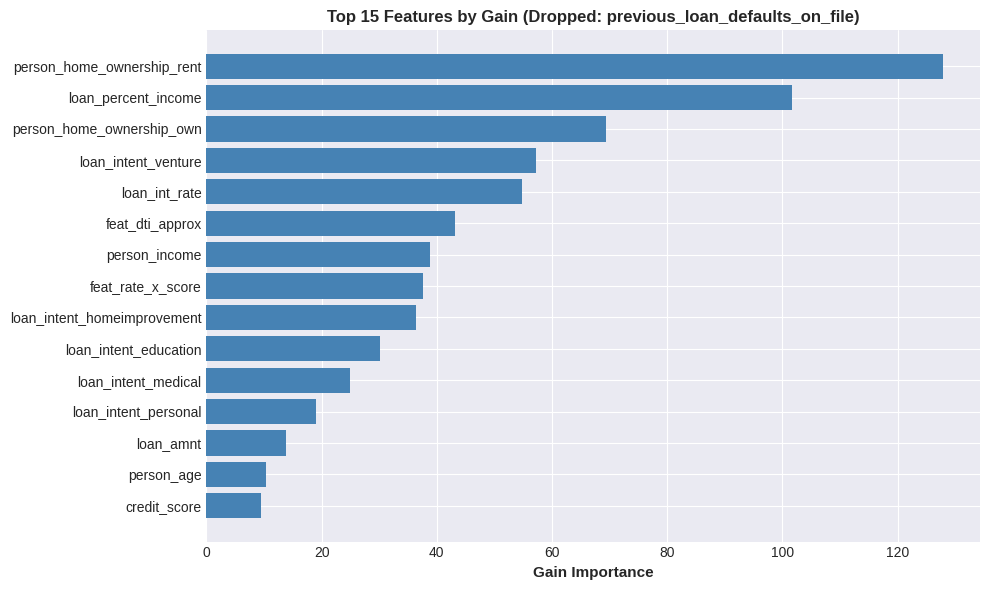

In [25]:
gain = model.get_booster().get_score(importance_type="gain")
imp_df = pd.DataFrame({
    "feature": list(gain.keys()),
    "importance": list(gain.values())
}).sort_values("importance", ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
top_n = 15
ax.barh(range(top_n), imp_df["importance"].head(top_n).values, color='steelblue')
ax.set_yticks(range(top_n))
ax.set_yticklabels(imp_df["feature"].head(top_n).values, fontsize=10)
ax.set_xlabel('Gain Importance', fontsize=11, fontweight='bold')
ax.set_title(f'Top {top_n} Features by Gain (Dropped: {key_feat})', fontsize=12, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('/content/feature_gain.png', dpi=300, bbox_inches='tight')
plt.show()

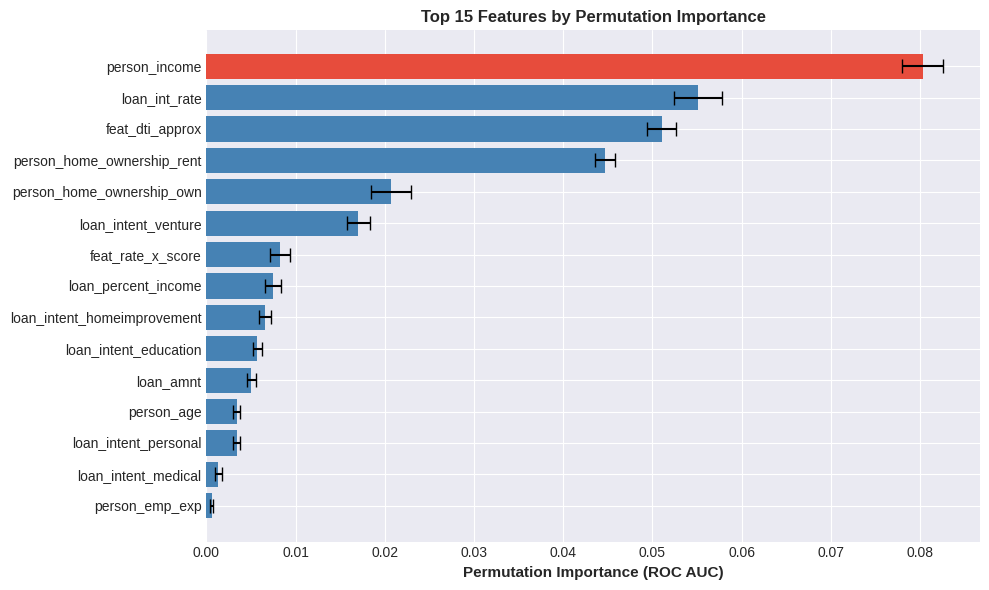

In [26]:
perm = permutation_importance(model, X_test_drop, y_test, scoring="roc_auc",
                               n_repeats=10, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({
    "feature": X_test_drop.columns,
    "importance": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("importance", ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
top_n = 15
colors = ['#e74c3c' if i == 0 else 'steelblue' for i in range(top_n)]
ax.barh(range(top_n), perm_df["importance"].head(top_n).values,
        xerr=perm_df["std"].head(top_n).values, color=colors, capsize=5)
ax.set_yticks(range(top_n))
ax.set_yticklabels(perm_df["feature"].head(top_n).values, fontsize=10)
ax.set_xlabel('Permutation Importance (ROC AUC)', fontsize=11, fontweight='bold')
ax.set_title(f'Top {top_n} Features by Permutation Importance', fontsize=12, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('/content/feature_permutation.png', dpi=300, bbox_inches='tight')
plt.show()

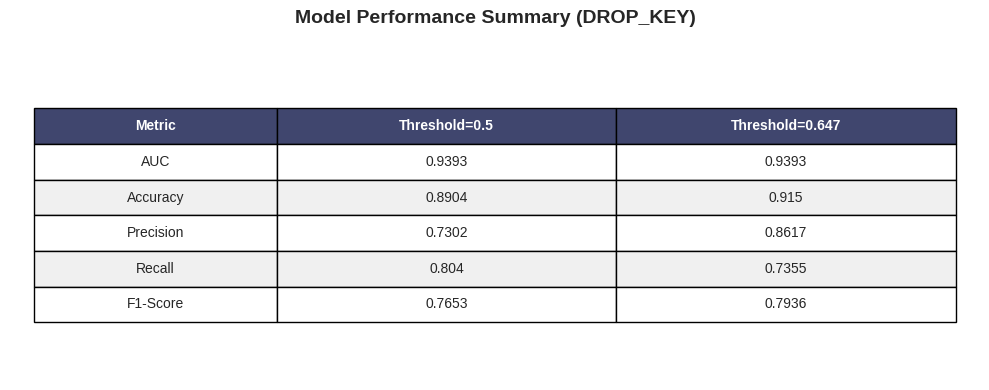

In [28]:
summary_df = pd.DataFrame({
    "Metric": ["AUC", "Accuracy", "Precision", "Recall", "F1-Score"],
    "Threshold=0.5": [auc_score, acc_05, prec_05, rec_05, f1_05],
    f"Threshold={best_thr:.3f}": [auc_score, acc_opt, prec_opt, rec_opt, f1_opt]
})


metrics = summary_df["Metric"].values
numeric_data = summary_df.iloc[:, 1:].values.round(4)

fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')


table_data = np.column_stack([metrics, numeric_data])

table = ax.table(cellText=table_data,
                colLabels=summary_df.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.25, 0.35, 0.35])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(len(summary_df.columns)):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, len(summary_df) + 1):
    for j in range(len(summary_df.columns)):
        table[(i, j)].set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

plt.title('Model Performance Summary (DROP_KEY)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('/content/performance_summary.png', dpi=300, bbox_inches='tight')
plt.show()